In [1]:
import torch
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from torch.utils.data import Dataset, DataLoader

# 주식데이터 불러오기

### 종목코드와 링크 생성

In [2]:
code_df = pd.read_html('http://kind.krx.co.kr/corpgeneral/corpList.do?method=download&searchType=13', header=0)[0]
code_df.종목코드 = code_df.종목코드.map('{:06d}'.format)

In [3]:
#상장된 기업들목록에서 회사명과 종목코드만 가져옴
code_df = code_df[['회사명', '종목코드']]
code_df = code_df.rename(columns={'회사명':'name', '종목코드':'code'})
code_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2354 entries, 0 to 2353
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   name    2354 non-null   object
 1   code    2354 non-null   object
dtypes: object(2)
memory usage: 36.9+ KB


In [4]:
#회사명을 넣으면, code_df를 뒤져서 종목코드를 찾고, 네이버주식url에 덧대서 출력해주는 함수
def get_url(item_name, code_df):
    code = code_df.query("name=='{}'".format(item_name))['code'].to_string(index=False)
    code = code[1:7]
    url = 'http://finance.naver.com/item/sise_day.nhn?code={code}'.format(code=code)
    print("요청 URL = {}".format(url))
    return url

item_name = '셀트리온'
url = get_url(item_name, code_df)

요청 URL = http://finance.naver.com/item/sise_day.nhn?code=068270


### 날짜별 종가, 전일비, 시가, 고가, 저가, 거래량 불러오기

In [5]:
def convert_col_name_kor_eng(df):  
    df = df.rename(columns= {'날짜': 'date', '종가': 'close', '전일비': 'diff', '시가': 'open', '고가': 'high', '저가': 'low', '거래량': 'volume'}) 
    df[['close', 'diff', 'open', 'high', 'low', 'volume']] = df[['close', 'diff', 'open', 'high', 'low', 'volume']].astype(int) 
    df['date'] = pd.to_datetime(df['date'])
    df = df.sort_values(by=['date'], ascending=True) 
    df.head()
    return df

def get_dataset(num_date):
    df = pd.DataFrame()
    for page in range(1,num_date+1):
        pg_url = '{url}&page={page}'.format(url=url, page=page)
        df = df.append(pd.read_html(pg_url, header=0)[0], ignore_index=True)
    df = df.dropna()
    df = convert_col_name_kor_eng(df)
    return df

df = get_dataset(370)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3693 entries, 5538 to 1
Data columns (total 7 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   date    3693 non-null   datetime64[ns]
 1   close   3693 non-null   int32         
 2   diff    3693 non-null   int32         
 3   open    3693 non-null   int32         
 4   high    3693 non-null   int32         
 5   low     3693 non-null   int32         
 6   volume  3693 non-null   int32         
dtypes: datetime64[ns](1), int32(6)
memory usage: 144.3 KB


### 데이터프레임 -> 넘파이

In [7]:
df = df.drop(['date'], axis=1)
df_size = len(df)
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3693 entries, 5538 to 1
Data columns (total 6 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   close   3693 non-null   int32
 1   diff    3693 non-null   int32
 2   open    3693 non-null   int32
 3   high    3693 non-null   int32
 4   low     3693 non-null   int32
 5   volume  3693 non-null   int32
dtypes: int32(6)
memory usage: 115.4 KB


In [8]:
print(df_size)

3693


In [9]:
train_set = df[0:int(df_size*0.7)]

In [10]:
test_set = df[int(df_size*0.7):]

In [11]:
train = train_set.to_numpy()
test = test_set.to_numpy()

In [12]:
print(train.shape)
print(test.shape)
print(train[1])
print(train[2])

(2585, 6)
(1108, 6)
[  6550   1150   7690   7690   6550 422688]
[  5740    810   6450   6580   5730 182685]


# 데이터 전처리

#### minmax정규화, RNN용 shape으로 변경

In [13]:
def minmax_scaler(data):
    print(np.min(data,0))
    numerator = data - np.min(data,0)
    print(numerator.shape)
    denominator = np.max(data,0) - np.min(data,0)
    print(numerator.shape)
    return numerator / (denominator + 1e-7)

def build_dataset(time_series, seq_length):
    train_size = int(len(time_series - seq_length))
    dataX = []
    dataY = []

    for i in range(0, len(time_series)-seq_length):
        _x = time_series[i:i + seq_length,1:]
        _y = time_series[i + seq_length,[0]]
        dataX.append(_x)
        dataY.append(_y)
        
    return np.array(dataX), np.array(dataY)
#2차원 배열 -> 넘파이배열로 변경시 자료의 사이즈가 맞지 않으면 object타입으로 처리해서 3차원배열로 인식하지 않는다.

In [14]:
train = minmax_scaler(train)
test_min = np.min(test, 0)
test_max = np.max(test, 0)
test_denom = test_max - test_min
test_minmax = (test-test_min) / (test_denom + 1e-7)#minmax_scaler(test) 
print(train_set.shape)
print(test_set.shape)

[2270    0    0    0    0    0]
(2585, 6)
(2585, 6)
(2585, 6)
(1108, 6)


In [15]:
print(test_min)

[ 76700      0  77900  78600  76300 160767]


In [16]:
seq_length = 7

In [17]:
trainX, trainY = build_dataset(train, seq_length)
testX, testY = build_dataset(test_minmax, seq_length)
print(trainX.shape, trainY.shape)
print(testX.shape, testY.shape)

(2578, 7, 5) (2578, 1)
(1101, 7, 5) (1101, 1)


### 넘파이 -> 텐서

In [18]:
class data_loader(Dataset):
    def __init__(self, samples, labels, t):
        self.samples = samples
        self.labels = labels
        self.T = t

    def __getitem__(self, index):
        sample, target = self.samples[index], self.labels[index]
        if self.T:
            return self.T(sample), target
        else:
            return sample, target

    def __len__(self):
        return len(self.samples)

In [19]:
def load(batch_size):
    transform = None
    train_set = data_loader(trainX, trainY, transform)
    train_loader = DataLoader(train_set, batch_size=batch_size, shuffle=True, drop_last=True)
    test_set = data_loader(testX, testY, transform)
    test_loader = DataLoader(test_set, batch_size=batch_size, shuffle=False)
    return train_loader, test_loader

In [20]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


# 학습 모델

In [21]:
data_dim = 5
hidden_dim = 100
output_dim = 1
lr = 0.0001
epoch = 100

batch_size=512
layers=4

In [22]:
train_loader, test_loader= load(batch_size=batch_size)

In [23]:
class Net(torch.nn.Module):
    def __init__(self, input_dim, hidden_dim, output_dim, layers):
        super(Net, self).__init__()
        self.rnn = torch.nn.LSTM(input_dim, hidden_dim, num_layers=layers, batch_first=True)
        
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(hidden_dim, 25),# bias=True),
            torch.nn.ReLU(),
            torch.nn.Linear(25, output_dim)#, bias=True)
        )
    def forward(self, x):
        x, _status  = self.rnn(x)
        x = self.fc(x[:,-1])
        return x
              
model = Net(data_dim, hidden_dim, output_dim, layers).to(device)

In [24]:
loss_func = torch.nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=lr)

In [25]:
loss_arr = []
for i in range(epoch):
    for j, [x, y] in enumerate(train_loader):
        train_x = x.to(device).float()
        train_y = y.to(device).float()
        optimizer.zero_grad()
        outputs = model.forward(train_x)
        
        #print(outputs.shape, train_y.shape)
        #print(outputs.dtype, train_y.dtype)
        
        loss = loss_func(outputs, train_y)
        #이걸 변수명을 같게하면 안되지!
        loss.backward()
        optimizer.step()
        loss_arr.append(loss)
    print(i, loss)

0 tensor(0.1362, device='cuda:0', grad_fn=<MseLossBackward>)
1 tensor(0.1260, device='cuda:0', grad_fn=<MseLossBackward>)
2 tensor(0.1229, device='cuda:0', grad_fn=<MseLossBackward>)
3 tensor(0.1264, device='cuda:0', grad_fn=<MseLossBackward>)
4 tensor(0.1104, device='cuda:0', grad_fn=<MseLossBackward>)
5 tensor(0.1181, device='cuda:0', grad_fn=<MseLossBackward>)
6 tensor(0.1117, device='cuda:0', grad_fn=<MseLossBackward>)
7 tensor(0.1046, device='cuda:0', grad_fn=<MseLossBackward>)
8 tensor(0.1172, device='cuda:0', grad_fn=<MseLossBackward>)
9 tensor(0.1050, device='cuda:0', grad_fn=<MseLossBackward>)
10 tensor(0.1001, device='cuda:0', grad_fn=<MseLossBackward>)
11 tensor(0.1069, device='cuda:0', grad_fn=<MseLossBackward>)
12 tensor(0.0933, device='cuda:0', grad_fn=<MseLossBackward>)
13 tensor(0.0943, device='cuda:0', grad_fn=<MseLossBackward>)
14 tensor(0.0740, device='cuda:0', grad_fn=<MseLossBackward>)
15 tensor(0.0540, device='cuda:0', grad_fn=<MseLossBackward>)
16 tensor(0.0508, 

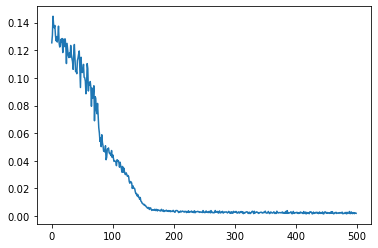

In [26]:
plt.plot(loss_arr)
plt.show()

## 모델 테스트

In [27]:
testX_tensor = torch.FloatTensor(testX)
testY_tensor = torch.FloatTensor(testY)

In [28]:
correct = 0
total = 0
loss_arr = []

model.eval()
with torch.no_grad():
    for j, [x, y] in enumerate(test_loader):
        #test_x = x.to(device).float()
        #test_y = y.to(device).float()
        test_x = testX_tensor.to(device).float()
        test_y = testY_tensor.to(device).float()
        predicted = model.forward(test_x)
        loss = loss_func(predicted, test_y)
        
        total += y.size(0)
        #print(y.shape, predicted.shape)
        #print(y, predicted)
        loss_arr.append(loss)
        #print(i, loss)
    # 테스트 데이터 전체에 대해 위의 작업을 시행한 후 정확도를 구해줍니다.
    #print("Accuracy of Test Data: {}%".format(float(correct) * 100 / total))

In [29]:
def show_result_graph(): 
    print(model)
    print('batch_size :',batch_size, ' layers: ', layers)
    plt.figure(figsize=(30,10))
    plt.plot(predicted.cpu())
    plt.plot(test_y.cpu())
    plt.legend(['predicted', 'test_y'])
    plt.grid(True)
    #plt.xticks([20*i for i in range(0,46)])
    plt.show()
    

Net(
  (rnn): LSTM(5, 100, num_layers=4, batch_first=True)
  (fc): Sequential(
    (0): Linear(in_features=100, out_features=25, bias=True)
    (1): ReLU()
    (2): Linear(in_features=25, out_features=1, bias=True)
  )
)
batch_size : 512  layers:  4


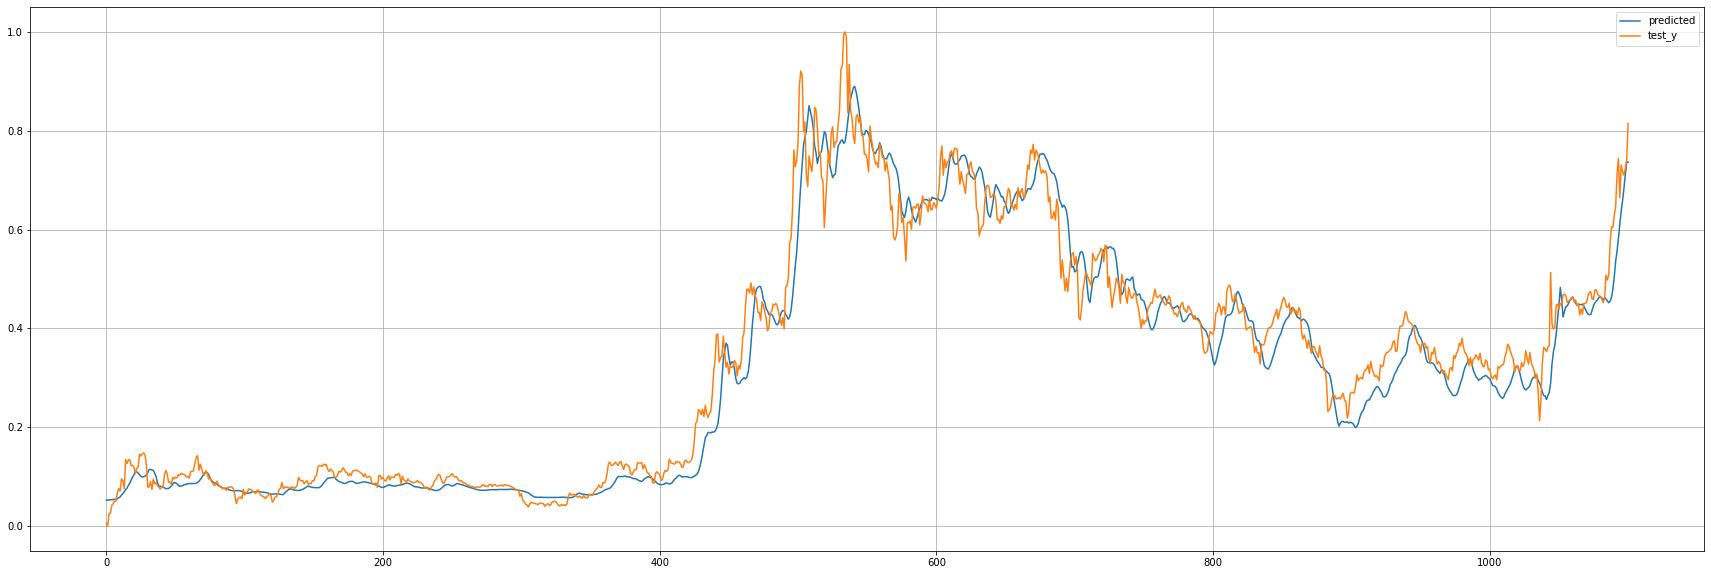

In [30]:
show_result_graph()

### 실제데이터 값으로 변환

In [31]:
print(testX.shape)
print(test_set.shape)
test[:,2]

(1101, 7, 5)
(1108, 6)


array([ 79300,  81000,  80800, ..., 289000, 291500, 305500])

In [32]:
predicted_y = predicted.cpu().numpy()#.astype('int')
test_y = testY_tensor.numpy()#.astype('int')
test_x = test[7:,2]
print(test_x.shape)

calculated_predicted_y = (predicted_y * (test_denom[0] + 1e-7)) + test_min[0]
calculated_test_y = (test_y * (test_denom[0] + 1e-7)) + test_min[0]
calculated_test_x = test_x #(test_x * (test_denom[2] + 1e-7)) + test_min[2] #open에대해 적용

calculated_predicted_y = calculated_predicted_y.astype('int')
calculated_test_y = calculated_test_y.astype('int')
calculated_test_x = calculated_test_x.astype('int')

(1101,)


In [34]:
from datetime import datetime, timedelta
today = datetime.today() - timedelta(days=1)
str_day = today.strftime('%Y-%m-%d')
print(str_day)

2020-06-23


In [35]:
calculated_test_x

array([ 80000,  77900,  79700, ..., 289000, 291500, 305500])

In [36]:
calculated_test_y

array([[ 78700],
       [ 76700],
       [ 84000],
       ...,
       [291500],
       [297000],
       [318500]])

In [37]:
day_length = len(predicted_y)
money = 0
count_acc = 0

for i in range(day_length-30, day_length):
    #당일 날짜 계산
    today = datetime.today() - timedelta(days=day_length) + timedelta(days=i)
    str_year  = today.strftime('%Y')[:2]
    str_today = str_year + today.strftime('-%m-%d')
    # 투자하면 벌돈 및 실제 벌돈 계산
    expect_money = calculated_predicted_y[i] - calculated_test_x[i]
    earn_money = calculated_test_y[i] - calculated_test_x[i]
    print(str_today, '시작가\t','\t', '종가\t', '\t', '수익예상')
    print('예상가\t', calculated_test_x[i],'\t', calculated_predicted_y[i], '\t',expect_money)
    print('현실가\t', calculated_test_x[i],'\t', calculated_test_y[i], '\t', earn_money)
    # 수익예상이면 투자후 금액 출력
    if (expect_money > 0):
        money = money + earn_money
    print('번돈\t', money)
    print('-----------------------------------------------------')
    # 수익 예측을 정확이 했는지 판단.
    if (expect_money >0) & (earn_money >0): count_acc = count_acc + 1
    if (expect_money <0) & (earn_money <0): count_acc = count_acc + 1

20-05-25 시작가	 	 종가	 	 수익예상
예상가	 211000 	 [203950] 	 [-7050]
현실가	 211000 	 [215000] 	 [4000]
번돈	 0
-----------------------------------------------------
20-05-26 시작가	 	 종가	 	 수익예상
예상가	 215000 	 [203750] 	 [-11250]
현실가	 215000 	 [217000] 	 [2000]
번돈	 0
-----------------------------------------------------
20-05-27 시작가	 	 종가	 	 수익예상
예상가	 219000 	 [203874] 	 [-15126]
현실가	 219000 	 [217500] 	 [-1500]
번돈	 0
-----------------------------------------------------
20-05-28 시작가	 	 종가	 	 수익예상
예상가	 220000 	 [206345] 	 [-13655]
현실가	 220000 	 [213000] 	 [-7000]
번돈	 0
-----------------------------------------------------
20-05-29 시작가	 	 종가	 	 수익예상
예상가	 213000 	 [209129] 	 [-3871]
현실가	 213000 	 [213000] 	 [0]
번돈	 0
-----------------------------------------------------
20-05-30 시작가	 	 종가	 	 수익예상
예상가	 214500 	 [210825] 	 [-3675]
현실가	 214500 	 [218500] 	 [4000]
번돈	 0
-----------------------------------------------------
20-05-31 시작가	 	 종가	 	 수익예상
예상가	 218500 	 [211806] 	 [-6694]
현실가	 218500 	 [218500] 	 [

In [38]:
print('벌어들인돈 : {0:d}원'.format(int(money)))
print('정확도 : {0:.3f}%'.format(count_acc/30))

벌어들인돈 : 8000원
정확도 : 0.500%


In [39]:
len(predicted_y)

1101

## MinMAX검증 방법

In [40]:
test_min_ = np.min(test,0)[0]
test_max_ = np.max(test,0)[0]
test_denom_ = test_max_-test_min_

print(test_min_)
print(test_max_)
print(test_denom_)

print(test[:,0].shape)
print('----------')
print(test_min_.shape)
print(test_max_.shape)
print(test_denom_.shape)
print('----------')
test_mm = (test[:,0] -test_min_)/ (test_denom_ + 1e-7)


print((test_denom[0] + 1e-7).shape)
print(test_mm.shape)
print(test_y.reshape(-1,).shape)

calculated_mm_y = (test_mm * (test_denom_ + 1e-7)) + test_min_
calculated_test_y  = (test_y.reshape(-1,) * (test_denom_ + 1e-7)) + test_min_
print('----------')
print(calculated_mm_y.shape)
print(calculated_test_y.shape)
#print(calculated_y.astype('int'))

76700
373500
296800
(1108,)
----------
()
()
()
----------
()
(1108,)
(1101,)
----------
(1108,)
(1101,)


In [41]:
test_mm

array([0.00876011, 0.01145553, 0.01212938, ..., 0.72371968, 0.74225067,
       0.81469003])

In [42]:
test_y.reshape(-1,)

array([0.00673854, 0.        , 0.02459569, ..., 0.72371966, 0.7422507 ,
       0.81469005], dtype=float32)

In [43]:
calculated_mm_y[1091:1101]

array([227500., 224500., 227500., 247000., 256500., 256000., 263500.,
       268500., 288000., 297500.])

In [44]:
calculated_test_y[1091:1101]

array([268500.      , 288000.      , 297500.      , 274000.      ,
       293500.      , 289500.      , 287500.      , 291500.      ,
       297000.      , 318500.015625])

In [45]:
print(test[1091:1101])

[[ 227500   14000  214000  232500  213000 3410255]
 [ 224500    3000  230000  232500  222000 1115810]
 [ 227500    3000  231500  235000  224500 1813508]
 [ 247000   19500  227500  248000  227000 3037387]
 [ 256500    9500  244000  260500  243000 2899453]
 [ 256000     500  260500  263000  253000 1267019]
 [ 263500    7500  257000  264500  255000 1345656]
 [ 268500    5000  263500  270000  261500 1067682]
 [ 288000   19500  280000  299500  274500 3934710]
 [ 297500    9500  280000  303500  279000 3865779]]


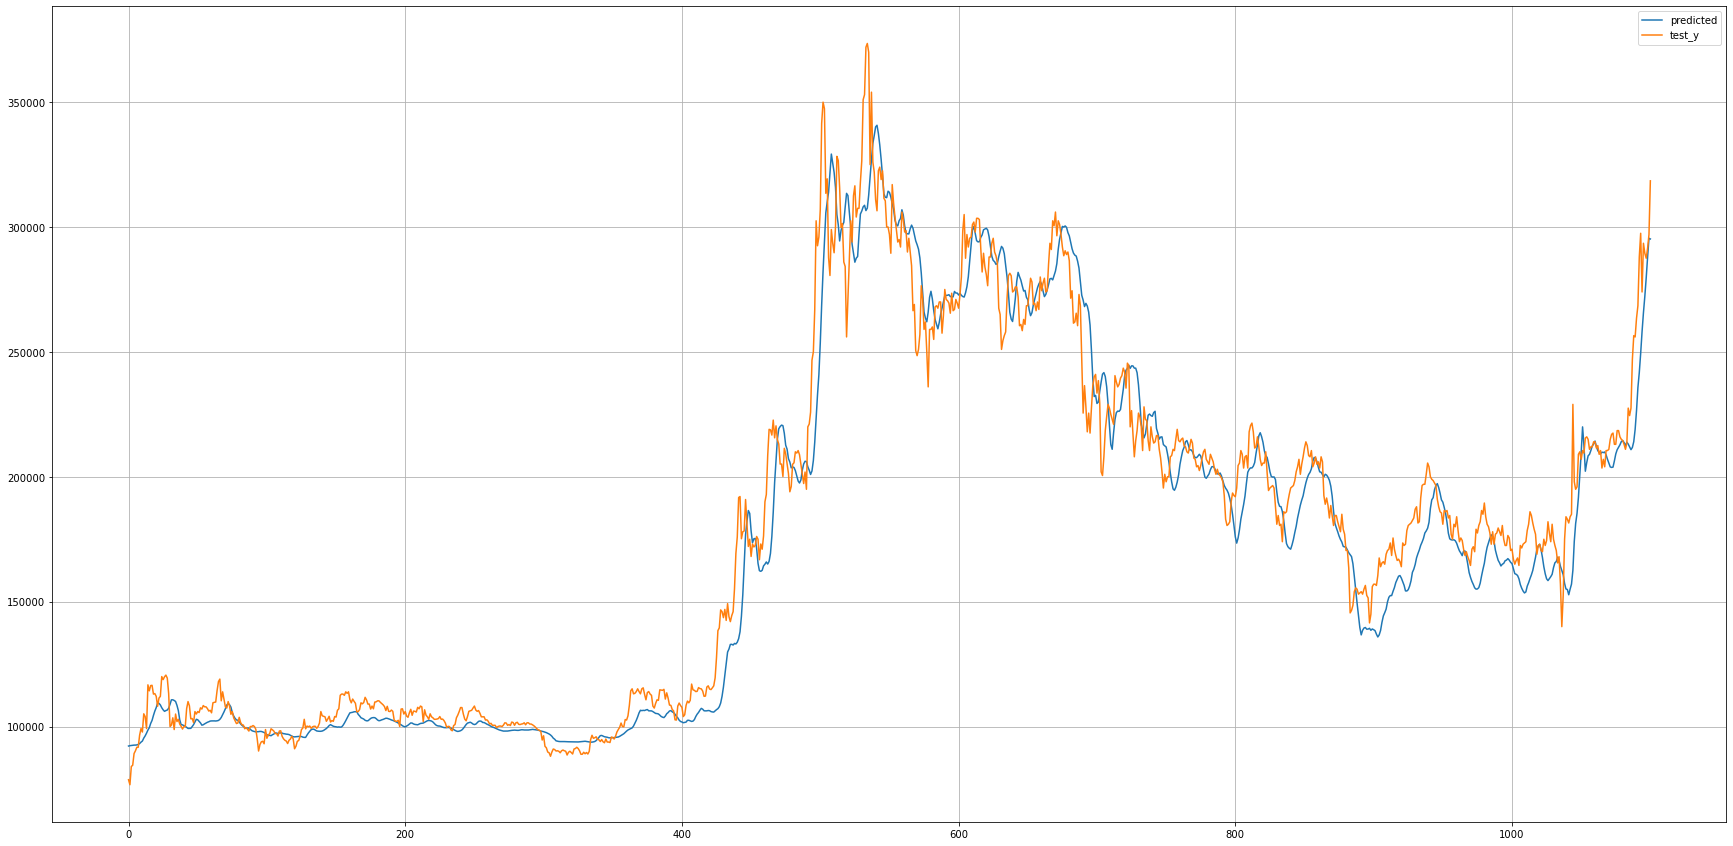

In [46]:
%matplotlib inline
plt.figure(figsize=(30,15))
plt.plot(calculated_predicted_y)
plt.plot(calculated_test_y)
plt.legend(['predicted', 'test_y'])
plt.grid(True)
#plt.xticks([20*i for i in range(0,46)])
plt.show()